# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial to play with it yourself.


# Install detectron2

In [ ]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

--2019-12-10 04:16:34--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.114.131
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.114.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: 'input.jpg'

input.jpg           100%[===================>] 204.32K   219KB/s    in 0.9s    

2019-12-10 04:16:36 (219 KB/s) - 'input.jpg' saved [209222/209222]



NameError: name 'cv2_imshow' is not defined

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) if you're not running a model in detectron2's core library
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

WARNING [10/15 06:33:09 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6073, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8766, 283.3257, 529.9404, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))

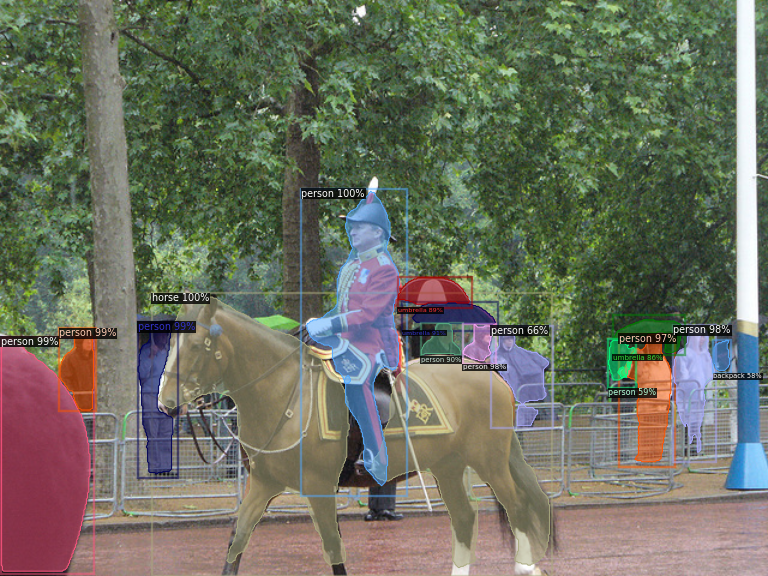

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
# download, decompress the data
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip balloon_dataset.zip > /dev/null

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [2]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools

# write a function that loads the dataset into detectron2's standard format
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")
print(balloon_metadata)

Metadata(name='balloon_train', thing_classes=['balloon'])


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



In [3]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

NameError: name 'cv2_imshow' is not defined

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [12/10 06:08:10 d2.config.compat]: Config '../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[12/10 06:08:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Co

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[12/10 06:08:16 d2.engine.train_loop]: Starting training from iteration 0
[12/10 06:08:22 d2.utils.events]: eta: 0:01:19  iter: 19  total_loss: 2.120  loss_cls: 0.676  loss_box_reg: 0.549  loss_mask: 0.694  loss_rpn_cls: 0.044  loss_rpn_loc: 0.010  time: 0.2860  data_time: 0.0034  lr: 0.000005  max_mem: 2672M
[12/10 06:08:28 d2.utils.events]: eta: 0:01:14  iter: 39  total_loss: 2.085  loss_cls: 0.650  loss_box_reg: 0.638  loss_mask: 0.669  loss_rpn_cls: 0.061  loss_rpn_loc: 0.015  time: 0.2869  data_time: 0.0037  lr: 0.000010  max_mem: 2672M
[12/10 06:08:34 d2.utils.events]: eta: 0:01:08  iter: 59  total_loss: 1.882  loss_cls: 0.575  loss_box_reg: 0.660  loss_mask: 0.603  loss_rpn_cls: 0.018  loss_rpn_loc: 0.004  time: 0.2864  data_time: 0.0037  lr: 0.000015  max_mem: 2672M
[12/10 06:08:39 d2.utils.events]: eta: 0:01:02  iter: 79  total_loss: 1.634  loss_cls: 0.526  loss_box_reg: 0.535  loss_mask: 0.542  loss_rpn_cls: 0.045  loss_rpn_loc: 0.008  time: 0.2855  data_time: 0.0035  lr: 0.0

OrderedDict()

In [2]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard -h

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 0).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Contents of stdout:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]

TensorBoard is a suite of web applicatio

In [2]:
!kill 9461

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

NameError: name 'cv2_imshow' is not defined

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [5]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")

WARNING [12/10 06:11:27 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'balloon_val'
[12/10 06:11:27 d2.data.datasets.coco]: Converting dataset annotations in 'balloon_val' to COCO format ...)
[12/10 06:11:28 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/10 06:11:28 d2.data.datasets.coco]: Conversion finished, num images: 13, num annotations: 50
[12/10 06:11:28 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/balloon_val_coco_format.json


In [10]:

val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [12/10 04:30:03 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'balloon_val'
[12/10 04:30:03 d2.data.datasets.coco]: Converting dataset annotations in 'balloon_val' to COCO format ...)
[12/10 04:30:04 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/10 04:30:04 d2.data.datasets.coco]: Conversion finished, num images: 13, num annotations: 50
[12/10 04:30:04 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/balloon_val_coco_format.json
[12/10 04:30:04 d2.data.build]: Distribution of training instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[12/10 04:30:04 d2.evaluation.evaluator]: Start inference on 13 images
[12/10 04:30:11 d2.evaluation.evaluator]: Total inference time: 0:00:02 (0.250000 s / img per device, on 1 devices)
[12/10 04:30:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00

OrderedDict([('bbox',
              {'AP': 69.7243741220557,
               'AP50': 86.62577690311568,
               'AP75': 84.96175194532081,
               'APs': 28.316831683168314,
               'APm': 55.13157063582573,
               'APl': 82.96387800479741}),
             ('segm',
              {'AP': 78.82238567552919,
               'AP50': 86.21941952529646,
               'AP75': 85.1680500446091,
               'APs': 11.93187715069539,
               'APm': 59.996571085679996,
               'APl': 94.85937165145086})])

# Other types of builtin models

WARNING [10/15 06:33:32 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


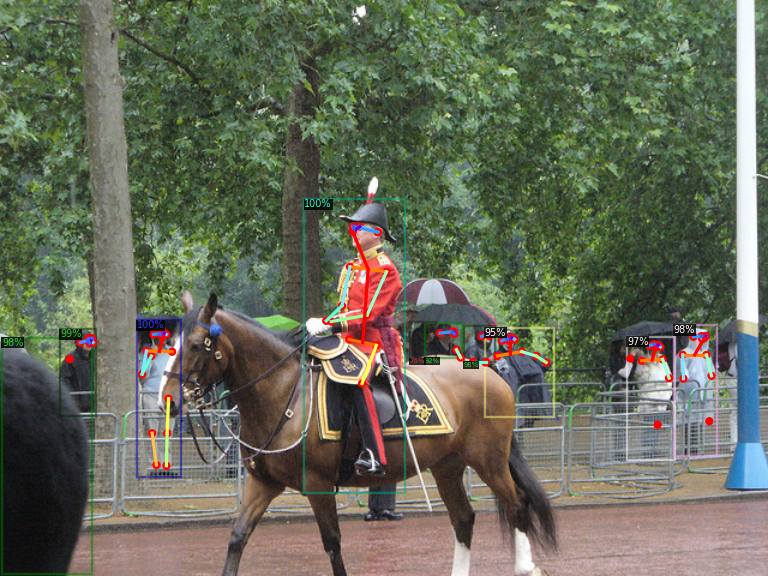

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

WARNING [10/15 06:33:37 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


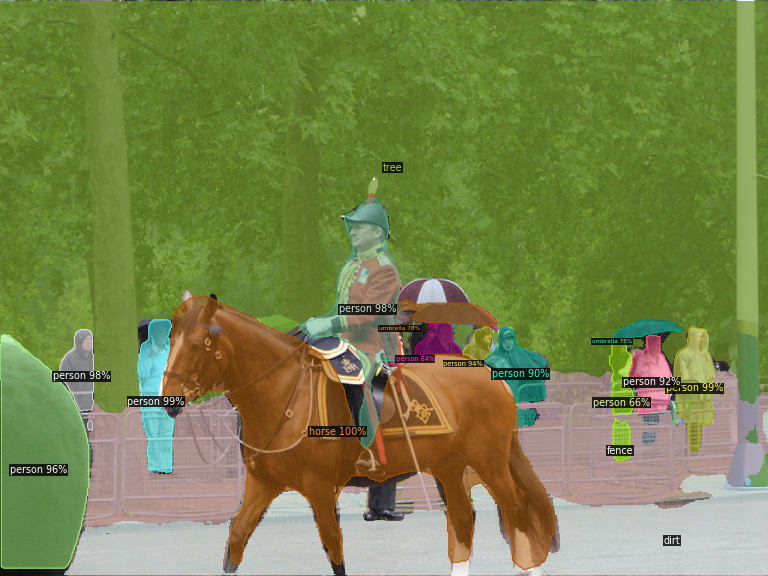

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

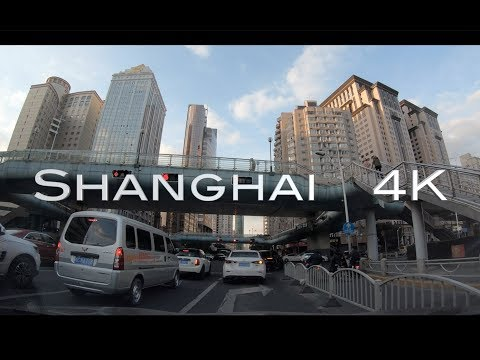

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!cd detectron2_repo && python demo/demo.py --config-file configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input ../video-clip.mp4 --confidence-threshold 0.6 --output ../video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')